In [ ]:
!pip install albumentations wandb nbformat opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import nbformat
import cv2

from collections import Counter
import logging
import os

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [ ]:
data_transforms = {
    "train": A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.3),
        #A.RandomBrightnessContrast(brightness_limit=(-0.2,0.2), contrast_limit=(-0.3, 0.3), p=0.3),
        #A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=30, val_shift_limit=20, p=0.2),
        A.GaussNoise(var_limit=(10, 50), p=0.1),
        A.CLAHE(clip_limit=(1,3), tile_grid_size=(8, 8), p=0.3),
        #A.RandomCrop(224, 224, 0.3),  # RandomCrop to introduce variability
        # A.CenterCrop(height=224, width=224, p=0.3),
        # choose mean and std based on pre-trained model specification.
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "validation": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    "test": A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
}


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dir_root, split, transform=None, resize=None):
        self.dir_root = dir_root
        self.split = split
        self.transform = transform
        self.resize = resize
        self.data = []
        self.targets = []
        self.class_names = []

        data_dir = os.path.join(dir_root, split)

        class_directories = sorted(os.listdir(data_dir))
        for class_idx, class_dir in enumerate(class_directories):
            class_path = os.path.join(data_dir, class_dir)
            self.class_names.append(class_dir)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.data.append(img_path)
                self.targets.append(class_idx)

        self.class_idx_to_name = {idx: name for idx, name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        target = self.targets[idx]

        try:
            image = cv2.imread(img_path)

            if self.resize:
                image = cv2.resize(image, (self.resize, self.resize))

            if self.transform:
                image = self.transform(image=image)['image']

            return image, target

        except Exception as e:
            print(f"Error loading image: {e}")
            return None, None

    def num_classes(self):
        return len(self.class_names)

    def get_class_name(self, class_idx):
        return self.class_idx_to_name.get(class_idx)

    def get_class_names(self):
        return self.class_names

    def class_idx_to_name_dict(self):
        return self.class_idx_to_name

    def get_classes_frequencies(self):
        return dict(Counter(self.targets))

In [ ]:
data_directory = "/content/drive/MyDrive/original(resized)"

In [ ]:
training_dataset = CustomDataset(dir_root=data_directory, split='train', transform=data_transforms['train'])
validation_dataset = CustomDataset(dir_root=data_directory, split='validation', transform=data_transforms['validation'])
test_dataset = CustomDataset(dir_root=data_directory, split='test', transform=data_transforms['test'])

In [ ]:
print(training_dataset.num_classes())
print(training_dataset.get_class_names())
print(training_dataset.get_classes_frequencies())

8
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
{0: 128, 1: 128, 2: 128, 3: 128, 4: 128, 5: 128, 6: 128, 7: 135}


In [ ]:
# pin_memory=Ture allows faster transfer of data from host (CPU) to device (GPU) memory
train_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
model

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
in_features = model.classifier.fc.in_features

model.classifier = torch.nn.Sequential(
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(0.2, inplace=False),
    torch.nn.Linear(in_features=in_features, out_features=512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(1024, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.3),
    torch.nn.Linear(1024, training_dataset.num_classes()),
)

In [ ]:
model

EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [ ]:
for name, param in model.named_parameters():
    if 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [ ]:
# model = torch.compile(model)

In [ ]:
num_epochs = 40
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=1e-4)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=3, eta_min=0.001)

In [ ]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    notes="frozen; CALCULATE ENERGY; 3 layers; data augmentation",
    save_code=False,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "architecture": "efficientnet",
        "dataset": "augmented"
    },
)

In [ ]:
wandb.watch(model, log="all")

[]

In [ ]:
from tqdm import tqdm

In [ ]:
def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()

    # if epoch == 6:
    #     for param in model.parameters():
    #         param.requires_grad = True

    running_loss = 0.0
    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss/len(dataloader)
    print(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(training_dataset.num_classes()), yticklabels=range(training_dataset.num_classes()))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    print(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [ ]:
import copy

f1_best = float('-inf')
best_model_state_dict = None
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, train_dataloader, criterion, optimizer, device)
    _, _, _, _, f1 = validation(epoch, model, val_dataloader, criterion, device)

    if f1 > f1_best:
        f1_best = f1
        best_model_state_dict = copy.deepcopy(model.state_dict())

if best_model_state_dict:
    model.load_state_dict(best_model_state_dict)

100%|██████████| 33/33 [00:16<00:00,  2.05it/s]

Epoch: [1], Training Loss:  1.3425



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: [1], Validation Loss:  1.0023, Accuracy:  0.6250, Precision:  0.6133, Recall:  0.6250, F1 Score:  0.5996


100%|██████████| 33/33 [00:11<00:00,  2.83it/s]

Epoch: [2], Training Loss:  0.6492


Epoch: [2], Validation Loss:  0.7694, Accuracy:  0.7031, Precision:  0.7478, Recall:  0.7031, F1 Score:  0.7019


100%|██████████| 33/33 [00:09<00:00,  3.40it/s]

Epoch: [3], Training Loss:  0.5057


Epoch: [3], Validation Loss:  0.5083, Accuracy:  0.8125, Precision:  0.8330, Recall:  0.8125, F1 Score:  0.8170


100%|██████████| 33/33 [00:09<00:00,  3.59it/s]

Epoch: [4], Training Loss:  0.4481


Epoch: [4], Validation Loss:  0.4395, Accuracy:  0.7969, Precision:  0.8110, Recall:  0.7969, F1 Score:  0.7988


100%|██████████| 33/33 [00:11<00:00,  2.83it/s]

Epoch: [5], Training Loss:  0.4525


Epoch: [5], Validation Loss:  0.4675, Accuracy:  0.8359, Precision:  0.8336, Recall:  0.8359, F1 Score:  0.8331


100%|██████████| 33/33 [00:11<00:00,  2.87it/s]

Epoch: [6], Training Loss:  0.3772


Epoch: [6], Validation Loss:  0.4258, Accuracy:  0.8516, Precision:  0.8694, Recall:  0.8516, F1 Score:  0.8436


100%|██████████| 33/33 [00:23<00:00,  1.39it/s]

Epoch: [7], Training Loss:  0.3627


Epoch: [7], Validation Loss:  0.3754, Accuracy:  0.8750, Precision:  0.8770, Recall:  0.8750, F1 Score:  0.8742


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]

Epoch: [8], Training Loss:  0.3096


Epoch: [8], Validation Loss:  0.4278, Accuracy:  0.8359, Precision:  0.8405, Recall:  0.8359, F1 Score:  0.8278


100%|██████████| 33/33 [00:11<00:00,  2.86it/s]

Epoch: [9], Training Loss:  0.3450


Epoch: [9], Validation Loss:  0.3961, Accuracy:  0.8203, Precision:  0.8424, Recall:  0.8203, F1 Score:  0.8196


100%|██████████| 33/33 [00:09<00:00,  3.43it/s]

Epoch: [10], Training Loss:  0.2748


Epoch: [10], Validation Loss:  0.4202, Accuracy:  0.8516, Precision:  0.8602, Recall:  0.8516, F1 Score:  0.8518


100%|██████████| 33/33 [00:10<00:00,  3.15it/s]

Epoch: [11], Training Loss:  0.3054


Epoch: [11], Validation Loss:  0.3600, Accuracy:  0.8750, Precision:  0.8881, Recall:  0.8750, F1 Score:  0.8759


100%|██████████| 33/33 [00:11<00:00,  2.76it/s]

Epoch: [12], Training Loss:  0.2876


Epoch: [12], Validation Loss:  0.3843, Accuracy:  0.8750, Precision:  0.8843, Recall:  0.8750, F1 Score:  0.8737


100%|██████████| 33/33 [00:09<00:00,  3.33it/s]

Epoch: [13], Training Loss:  0.2692


Epoch: [13], Validation Loss:  0.4138, Accuracy:  0.8672, Precision:  0.8938, Recall:  0.8672, F1 Score:  0.8669


100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

Epoch: [14], Training Loss:  0.2122


Epoch: [14], Validation Loss:  0.3433, Accuracy:  0.8828, Precision:  0.9100, Recall:  0.8828, F1 Score:  0.8860


100%|██████████| 33/33 [00:12<00:00,  2.72it/s]

Epoch: [15], Training Loss:  0.2661


Epoch: [15], Validation Loss:  0.3189, Accuracy:  0.8828, Precision:  0.8860, Recall:  0.8828, F1 Score:  0.8823


100%|██████████| 33/33 [00:10<00:00,  3.06it/s]

Epoch: [16], Training Loss:  0.1977


Epoch: [16], Validation Loss:  0.3538, Accuracy:  0.8906, Precision:  0.9126, Recall:  0.8906, F1 Score:  0.8910


100%|██████████| 33/33 [00:09<00:00,  3.65it/s]

Epoch: [17], Training Loss:  0.2446


Epoch: [17], Validation Loss:  0.3625, Accuracy:  0.8750, Precision:  0.8915, Recall:  0.8750, F1 Score:  0.8744


100%|██████████| 33/33 [00:11<00:00,  2.92it/s]

Epoch: [18], Training Loss:  0.2172


Epoch: [18], Validation Loss:  0.4005, Accuracy:  0.8672, Precision:  0.8697, Recall:  0.8672, F1 Score:  0.8660


100%|██████████| 33/33 [00:11<00:00,  2.85it/s]

Epoch: [19], Training Loss:  0.2570


Epoch: [19], Validation Loss:  0.3966, Accuracy:  0.8672, Precision:  0.8671, Recall:  0.8672, F1 Score:  0.8650


100%|██████████| 33/33 [00:09<00:00,  3.34it/s]

Epoch: [20], Training Loss:  0.2118


Epoch: [20], Validation Loss:  0.4762, Accuracy:  0.8594, Precision:  0.8629, Recall:  0.8594, F1 Score:  0.8580


100%|██████████| 33/33 [00:09<00:00,  3.51it/s]

Epoch: [21], Training Loss:  0.1628


Epoch: [21], Validation Loss:  0.3892, Accuracy:  0.8906, Precision:  0.9055, Recall:  0.8906, F1 Score:  0.8909


100%|██████████| 33/33 [00:11<00:00,  2.80it/s]

Epoch: [22], Training Loss:  0.2139


Epoch: [22], Validation Loss:  0.2945, Accuracy:  0.8906, Precision:  0.8989, Recall:  0.8906, F1 Score:  0.8931


100%|██████████| 33/33 [00:10<00:00,  3.03it/s]

Epoch: [23], Training Loss:  0.1750


Epoch: [23], Validation Loss:  0.3763, Accuracy:  0.8750, Precision:  0.8698, Recall:  0.8750, F1 Score:  0.8700


100%|██████████| 33/33 [00:08<00:00,  3.84it/s]

Epoch: [24], Training Loss:  0.1887


Epoch: [24], Validation Loss:  0.3854, Accuracy:  0.8672, Precision:  0.8870, Recall:  0.8672, F1 Score:  0.8696


100%|██████████| 33/33 [00:10<00:00,  3.02it/s]

Epoch: [25], Training Loss:  0.1703


Epoch: [25], Validation Loss:  0.4302, Accuracy:  0.8828, Precision:  0.8810, Recall:  0.8828, F1 Score:  0.8807


100%|██████████| 33/33 [00:11<00:00,  2.80it/s]

Epoch: [26], Training Loss:  0.2191


Epoch: [26], Validation Loss:  0.3514, Accuracy:  0.8906, Precision:  0.9007, Recall:  0.8906, F1 Score:  0.8918


100%|██████████| 33/33 [00:08<00:00,  3.75it/s]

Epoch: [27], Training Loss:  0.1519


Epoch: [27], Validation Loss:  0.3518, Accuracy:  0.8906, Precision:  0.8950, Recall:  0.8906, F1 Score:  0.8892


100%|██████████| 33/33 [00:11<00:00,  2.91it/s]

Epoch: [28], Training Loss:  0.1607


Epoch: [28], Validation Loss:  0.3831, Accuracy:  0.9062, Precision:  0.9079, Recall:  0.9062, F1 Score:  0.9059


100%|██████████| 33/33 [00:11<00:00,  2.82it/s]

Epoch: [29], Training Loss:  0.1735


Epoch: [29], Validation Loss:  0.3629, Accuracy:  0.8906, Precision:  0.8916, Recall:  0.8906, F1 Score:  0.8886


100%|██████████| 33/33 [00:09<00:00,  3.57it/s]

Epoch: [30], Training Loss:  0.1479


Epoch: [30], Validation Loss:  0.4425, Accuracy:  0.8906, Precision:  0.8988, Recall:  0.8906, F1 Score:  0.8920


100%|██████████| 33/33 [00:10<00:00,  3.11it/s]

Epoch: [31], Training Loss:  0.1648


Epoch: [31], Validation Loss:  0.4059, Accuracy:  0.8906, Precision:  0.9020, Recall:  0.8906, F1 Score:  0.8913


100%|██████████| 33/33 [00:11<00:00,  2.88it/s]

Epoch: [32], Training Loss:  0.1605


Epoch: [32], Validation Loss:  0.3627, Accuracy:  0.9062, Precision:  0.9133, Recall:  0.9062, F1 Score:  0.9066


100%|██████████| 33/33 [00:09<00:00,  3.39it/s]

Epoch: [33], Training Loss:  0.1532


Epoch: [33], Validation Loss:  0.3895, Accuracy:  0.8906, Precision:  0.8928, Recall:  0.8906, F1 Score:  0.8899


100%|██████████| 33/33 [00:09<00:00,  3.53it/s]

Epoch: [34], Training Loss:  0.1542


Epoch: [34], Validation Loss:  0.5422, Accuracy:  0.8984, Precision:  0.9028, Recall:  0.8984, F1 Score:  0.8974


100%|██████████| 33/33 [00:11<00:00,  2.89it/s]

Epoch: [35], Training Loss:  0.1735


Epoch: [35], Validation Loss:  0.4086, Accuracy:  0.8828, Precision:  0.8932, Recall:  0.8828, F1 Score:  0.8800


100%|██████████| 33/33 [00:10<00:00,  3.00it/s]

Epoch: [36], Training Loss:  0.1609


Epoch: [36], Validation Loss:  0.3148, Accuracy:  0.9297, Precision:  0.9305, Recall:  0.9297, F1 Score:  0.9296


100%|██████████| 33/33 [00:08<00:00,  3.85it/s]

Epoch: [37], Training Loss:  0.1473


Epoch: [37], Validation Loss:  0.3475, Accuracy:  0.9062, Precision:  0.9054, Recall:  0.9062, F1 Score:  0.9030


100%|██████████| 33/33 [00:11<00:00,  2.92it/s]

Epoch: [38], Training Loss:  0.1816


Epoch: [38], Validation Loss:  0.3383, Accuracy:  0.9375, Precision:  0.9372, Recall:  0.9375, F1 Score:  0.9355


100%|██████████| 33/33 [00:11<00:00,  2.93it/s]

Epoch: [39], Training Loss:  0.2092


Epoch: [39], Validation Loss:  0.3096, Accuracy:  0.8750, Precision:  0.8807, Recall:  0.8750, F1 Score:  0.8768


100%|██████████| 33/33 [00:09<00:00,  3.55it/s]

Epoch: [40], Training Loss:  0.1395


Epoch: [40], Validation Loss:  0.3351, Accuracy:  0.8828, Precision:  0.8838, Recall:  0.8828, F1 Score:  0.8827


Test Loss:  0.2161, Accuracy:  0.9000, Precision:  0.9035, Recall:  0.9000, F1 Score:  0.8937


(0.21611259831115603, 0.9, 0.9035114180625017, 0.9, 0.8937408622114504)

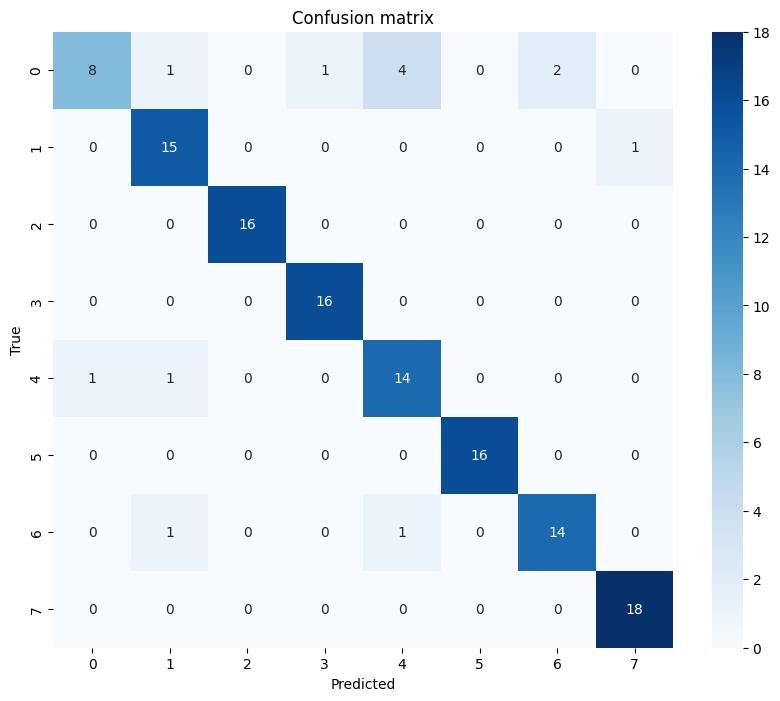

In [ ]:
test(model, test_dataloader, criterion, device)

In [ ]:
import numpy as np

def calculate_energy(outputs):
    return -torch.logsumexp(outputs, dim=1)

def analyze_energy_distribution(model, dataloader, device):
    model.eval()
    energies = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            energy = calculate_energy(outputs)
            energies.extend(energy.cpu().numpy())
    return energies

energies = analyze_energy_distribution(model, train_dataloader, device)

energy_threshold = np.percentile(energies, 95)

print(f"Energy Threshold: {energy_threshold}")

Energy Threshold: -3.7695096731185913


In [ ]:
model_name = 'efficientnet.pth'

torch.save(model.state_dict(), model_name)
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(model_name)

ArtifactManifestEntry(path='efficientnet.pth', digest='pOaHLGR7cD+Jg1b9y+lXCQ==', size=21074640, local_path='/root/.local/share/wandb/artifacts/staging/tmp68k_67hy', skip_cache=False)

In [ ]:
wandb.log_artifact(model_artifact)

<Artifact model>

In [ ]:
import numpy as np

def inference(model, image_path, device):
    image = Image.open(image_path)

    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    image = transform(image=np.array(image))['image']
    image_tr = torch.tensor(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image_tr)
        energy = calculate_energy(output)
        if energy > energy_threshold:
            print(f"The class is of unknown origin")
            print(f"Its energy is {energy}, but the threshold is {energy_threshold}")
            return
        prob = torch.softmax(output, dim=1)
        s, predicted_class = torch.max(prob,  1)
        print(f"Probability: {s}")
        print(f"Predicted class: {predicted_class}")
        print("-------------------------------------\n")
        return s

tests_dir = "/content/drive/MyDrive/test images"

avg = []

for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
    # avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")


<ipython-input-92-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


Probability: tensor([0.9963], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

Probability: tensor([0.9907], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-1.2354], device='cuda:0'), but the threshold is -3.7695096731185913
Probability: tensor([0.9699], device='cuda:0')
Predicted class: tensor([6], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-3.5889], device='cuda:0'), but the threshold is -3.7695096731185913
Probability: tensor([0.9838], device='cuda:0')
Predicted class: tensor([2], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-2.7985], device='cuda:0'), but the threshold is -3.7695096731185913
The class is of unknown origin
Its energy is tensor([-2.8249], device='cuda:0'), but the threshold is -3.7

In [ ]:
tests_dir = "/content/drive/MyDrive/original(resized)/test/Anthracnose_Fungi"

avg = []
for filename in os.listdir(tests_dir):
    image_path = os.path.join(tests_dir, filename)
    inference(model, image_path, device)
#     avg.append(torch.tensor(s, dtype=torch.float32))

# avg = torch.cat(avg)

# print(f"Avergae predicted probability: {torch.mean(avg)}")

<ipython-input-92-5163442a5a24>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_tr = torch.tensor(image).unsqueeze(0).to(device)


The class is of unknown origin
Its energy is tensor([-3.3248], device='cuda:0'), but the threshold is -3.7695096731185913
Probability: tensor([0.9682], device='cuda:0')
Predicted class: tensor([0], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-3.5822], device='cuda:0'), but the threshold is -3.7695096731185913
The class is of unknown origin
Its energy is tensor([-2.4417], device='cuda:0'), but the threshold is -3.7695096731185913
The class is of unknown origin
Its energy is tensor([-2.9247], device='cuda:0'), but the threshold is -3.7695096731185913
Probability: tensor([0.8781], device='cuda:0')
Predicted class: tensor([3], device='cuda:0')
-------------------------------------

The class is of unknown origin
Its energy is tensor([-3.1851], device='cuda:0'), but the threshold is -3.7695096731185913
Probability: tensor([0.9510], device='cuda:0')
Predicted class: tensor([1], device='cuda:0')
---------------------------------

In [ ]:
notebook_name = "/content/drive/MyDrive/Colab Notebooks/NN_resnet18_aug.ipynb"
with open(notebook_name) as f:
    nb = nbformat.read(f, as_version=4)
artifact = wandb.Artifact('notebook', type='notebook')
artifact.add_file(notebook_name)
wandb.log_artifact(artifact)

<Artifact notebook>

In [ ]:
wandb.finish()

accuracy,▁
f1 score,▁
precision,▁
recall,▁
test loss,▁
accuracy,0.9
f1 score,0.89374
precision,0.90351
recall,0.9
test loss,0.21611
